In [1]:
# %pip install git+https://github.com/lukegre/all_my_code/

In [2]:
%pylab inline
import xarray as xr
import pandas as pd
import all_my_code as amc
import matplotlib.pyplot as plt
import cartopy as ctp

Populating the interactive namespace from numpy and matplotlib


log-amc | version: 0.3.2.dev10+gdc963fe


In [3]:
ds_old = xr.open_dataset('../data/fgco2_lacroix-river_v20220218.nc')

In [38]:
area = ds_old.fgco2.spatial.get_area()
flux_per_pixel = (ds_old.fgco2 * area * 12.011 * 86400 * 365 * 1e-15)
lacroix_2022_ratio = 0.65 / flux_per_pixel.sum() 

In [90]:

ds_new = xr.Dataset()
ds_new['fgco2'] = (-ds_old.fgco2 * lacroix_2022_ratio).assign_attrs(
    units='mol/m2/s', 
    description='Regnier et al 2022: river adjustment fluxes scaled to 0.65 PgC/yr')

new_flux_per_pixel = (ds_new.fgco2 * area * 12.011 * 86400 * 365 * 1e-15)
ds_new['fgco2_basin'] = new_flux_per_pixel.spatial.aggregate_region(
    region_mask=ds_old.basins, 
    region_names=ds_old.basin.values,
    weights=xr.ones_like(ds_old.basins),
    func='sum').rename(region='basin').assign_attrs(units='PgC/yr')

ds_new['basins'] = ds_old.basins
ds_new = ds_new.assign_attrs(
    contact="Luke Gregor (luke.gregor@usys.ethz.ch)",
    created_by="original data by Fabrice Lacroix - scaled and integrated by Luke Gregor",
    date_created=pd.Timestamp.today().strftime('%Y-%m-%d'),
    warning="the adjustment should not be applied at local scales (i.e., sub-biome level)",
    reference="https://bg.copernicus.org/articles/17/55/2020/",
)

ds_new.to_netcdf('../data/fgco2_lacroix-river_v20220615.nc', encoding={k: {'dtype': 'float32', 'zlib': True} for k in ['fgco2']})

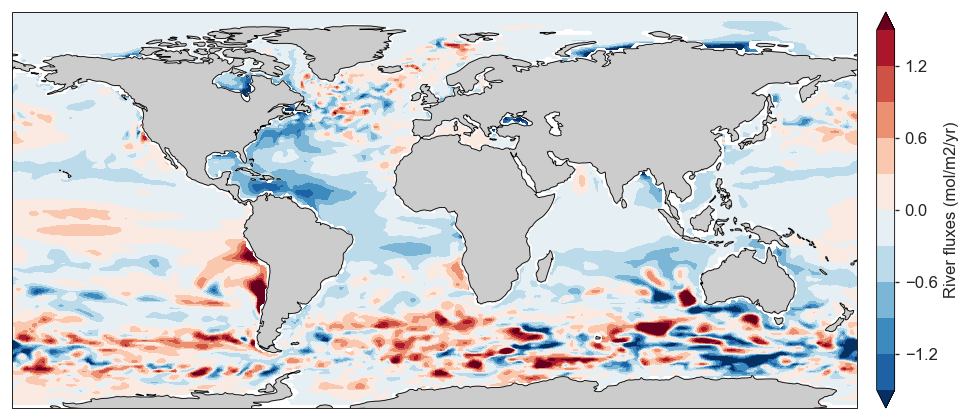

In [112]:
fig = plt.figure(figsize=[9, 4], dpi=120)
(ds_new.fgco2 * 365 * 86400).map.contourf(levels=11, land_color='#cccccc').colorbar.set_label('River fluxes (mol/m2/yr)')
fig.savefig('../figures/fgco2_lacroix-river_v20220615_scaled_regnier2022.png', bbox_inches='tight', dpi=200)

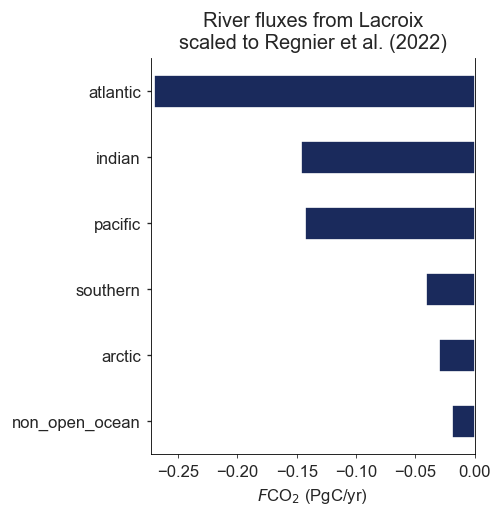

In [128]:
fig = plt.figure(figsize=[3,4], dpi=120)
ax = ds_new.fgco2_basin.to_series().sort_values(ascending=False).plot.barh(color='#1a2a5c')
ax.set_ylabel('')
ax.set_xlabel('$F$CO$_2$ (PgC/yr)')
ax.set_title('River fluxes from Lacroix\nscaled to Regnier et al. (2022)')
ax.spines['right'].set_visible(True)
fig.savefig('../figures/fgco2_lacroix-river_v20220615_scaled_regnier2022_regional.png', bbox_inches='tight', dpi=120)

In [91]:
ll -h ../data/

total 2064
-rw-r--r--  1 luke  staff   266K Mar  4 09:15 fgco2_lacroix-river_v20211223.nc
-rw-r--r--  1 luke  staff   527K Mar  4 09:15 fgco2_lacroix-river_v20220218.nc
-rw-r--r--  1 luke  staff   160K Jun 15 16:46 fgco2_lacroix-river_v20220615.nc
drwxr-xr-x  3 luke  staff    96B Mar  4 09:15 processed/
drwxr-xr-x  3 luke  staff    96B Mar  4 09:15 raw/
-rw-r--r--  1 luke  staff   7.7K Mar  4 09:15 reccap2_data.yml
drwxr-xr-x  8 luke  staff   256B Apr 12 10:29 regions/
-rw-r--r--  1 luke  staff   6.1K Mar  4 09:15 river_adjustment_basin.nc
